# NMF modeling for player recomendations
Non negative matrix factorization(NMF) is a feature reduction technique that decomposes a matrix into two smaller matricies that can be used to cluster features from the original matrix into topics as well as calculate the distance between samples in the original matrix to allow for recomendations between the closest samples to be created. I will be using NMF to generate player recomendations to find who has the cloest stats to some of the other best progressive defenders in the MLS. 

# Objective - Take target players from EDA and use NMF model as recomendation system for simular players. 

### 5.1 Load model and X.

### 5.2 create W(weight) matrix through NMF to get Skill set values for each player.

### 5.2 Create dataframes and labels from NMF output for player comparisons.

### 5.3 Target player recomendations from NMF.
- Nathan Cordoso 
- Julian Gressel
- Hector Jimenez
- Kai Wagner

### 5.4 conclusion and next steps 



## 5.1 Load model and X

In [1]:
## import packages and tools
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF 
from sklearn.preprocessing import Normalizer ,MaxAbsScaler
from sklearn.pipeline import make_pipeline
from utils import save_file,radar_compare, display_features, add_skill_group


In [2]:
## load nmf model 

expected_model_version = '1.0'
model_path = '../models/nmf.pkl'
if os.path.exists(model_path):
    with open(model_path, 'rb') as f:
        model = pickle.load(f)
#     if model.version != expected_model_version:
#         print("Expected model version doesn't match version loaded")
#     if model.sklearn_version != sklearn_version:
#         print("Warning: model created under different sklearn version")
else:
    print("Expected model not found")

model

NMF(init='nndsvda', l1_ratio=0.05, max_iter=1000, n_components=9,
    random_state=42)

In [3]:
## load data
X = pd.read_csv('../data/NMF_X.csv')
X.index= X['player_name'].values
X.drop('player_name',axis=1,inplace=True)
X.head()

,Tackle_pct_won,Nineties,xA,Key_pass,Comp_prog,Total_Cmp,Total_Att,Total_Cmp_pct,Total_Tot_Dist,Total_Prg_Dist,...,pAdj_def_interceptions,pAdj_Recoveries,pAdj_Aerial_Duels_lost,lost_tackles,True_tackle_pct,pAdj_Tackle_int_blocks,avg_shrt+med_pass_pct,pct_long_balls,prog_carry+lng_comp+crosses,attacking_touches
Carles Gil,26.4,25.4,0.472441,5.275591,10.905512,48.818898,65.708661,74.3,1016.102362,390.984252,...,1.537525,10.963222,0.267396,0.401093,25.000000,2.406561,84.50,27.022169,24.960630,51.653543
Julian Gressel,28.3,29.9,0.408027,3.210702,5.551839,37.324415,57.926421,64.4,812.374582,366.153846,...,3.767145,13.905196,1.661976,1.495778,31.506849,7.589689,78.10,30.600462,17.959866,33.143813
Emanuel Reynoso,29.2,26.5,0.332075,3.433962,8.830189,42.113208,61.056604,69.0,784.867925,292.981132,...,1.658520,12.162481,1.105680,0.982827,34.502924,6.695507,78.50,23.609394,18.792453,55.056604
Albert Rusnák,28.7,33.8,0.213018,2.573964,4.289941,40.739645,48.727811,83.6,839.289941,226.863905,...,1.304421,10.591897,0.208707,0.417415,32.876712,3.287140,91.15,24.833030,15.355030,30.857988
Maximiliano Moralez,30.2,26.5,0.362264,3.132075,7.735849,46.566038,62.415094,74.6,930.830189,318.000000,...,1.526455,11.083393,0.663676,1.460088,31.372549,5.043939,83.00,25.634825,18.188679,38.716981


## 5.2 create W(weight) matrix through NMF to get Skill set values for each player.

In [53]:
# Create a MaxAbsScaler: scaler
transformer = MaxAbsScaler().fit(X)

# scale data
scaled_X= transformer.transform(X)

nmf = model

W = nmf.fit_transform(scaled_X)
H = nmf.components_
err = nmf.reconstruction_err_

print(nmf,'error :',err, '\n', ' W shape',W.shape,'H shape ',H.shape)
df_new = add_skill_group(X,W)
print(df_new['pred_topic_num'].value_counts())
            
feature_names = X.columns.values
no_top_features = 4
no_top_players = 5

topics = display_features(H,W,feature_names, X, no_top_features,no_top_players)

NMF(init='nndsvda', l1_ratio=0.05, max_iter=1000, n_components=9,
    random_state=42) error : 16.097065673959523 
  W shape (541, 9) H shape  (9, 85)
7    99
8    98
5    87
6    79
4    70
3    48
2    40
0    18
1     2
Name: pred_topic_num, dtype: int64
Topic 0:
recept_pct (9.36) avg_shrt+med_pass_pct (8.98) pct_long_balls (8.19) touches_def_box (7.97)
488   Brad Guzan
518   Maxime Crépeau
526   Zac MacMath
530   David Ochoa
428   J.T. Marcinkowski
Topic 1:
dribble_Succ (2.71) num_dribble_past (2.63) dribble_Att (2.52) dispossed (2.31)
51   Yeferson Soteldo
2   Emanuel Reynoso
136   Brian Rodríguez
6   Lucas Zelarayán
0   Carles Gil
Topic 2:
pAdj_Clearences (2.37) pAdj_Blocked_shots (2.05) touches_def_3rd (1.81) pAdj_def_interceptions (1.49)
426   Nathan Cardoso
348   Alan Franco
417   Daniel Steres
365   Rudy Camacho
422   Francisco Calvo
Topic 3:
Total_Cmp_pct (1.71) avg_shrt+med_pass_pct (1.66) recept_pct (1.44) Long_Cmp_pct (1.28)
499   Kamohelo Mokotjo
459   Ralph Priso-Mbongu

## 5.3 create dataframes and labels for radar plot comparisons 

### 5.3.1. Create Skill get group ranking Dataframe for players from W matrix

In [54]:
skill_sets = pd.DataFrame(topics )
columns =['Defensive passing','Dribbling','Defensive actions','Short passing','Playing time','Tackling','Attacking play','Passing volume','Progressive passing']

skill_sets.columns = columns


dfw= pd.DataFrame(W,columns=columns,index = X.index)

for col in dfw.columns.values:
    title = col +' rank'
    dfw[title] = dfw[col].rank(pct=True,na_option = 'bottom',ascending=True)
dfw[['Defensive actions','Defensive actions rank']].nlargest(5,columns='Defensive actions rank')
dfw['player_name'] = dfw.index

### 5.3.2 Normalize W matrix and create key skill maxtrix for radar plots. 

In [93]:
# normalize values 

transformer = Normalizer().fit(W)
normed_W= transformer.transform(W)
# can add back club and salary here 
normed_df = pd.DataFrame(normed_W,index=X.index.values)


df = df = pd.read_csv('../data/final_per_90_and_pAdj.csv')
df.rename(columns={'prog_carry+lng_comp+crosses':'Progressive_play'},inplace=True)
# make df of only key features 
cdf = df[['player_name','Club',
       'Aerial_win_pct',
       'pAdj_Num_Dribblers_tackled',
       'pAdj_Num_Dribbled_past', 'pAdj_Clearences',
       'pAdj_Fouls','pAdj_Recoveries', 'True_tackle_pct',
       'pAdj_Tackle_int_blocks', 'attacking_touches',
       'pct_long_balls','Progressive_play',
       ]].copy()

cdf.rename(columns={'pAdj_Clearences':'Clearences','pAdj_Fouls':'Fouls',
                   'pAdj_Recoveries':'Recoveries',
                  'pAdj_Tackle_int_blocks':'Tackle_int_blocks','pAdj_Num_Dribblers_tackled':'Num_Dribblers_tackled',
                  'pAdj_Num_Dribbled_past':'Num_Dribbled_past'},inplace=True)

#column labels 
params = list(cdf.columns)[2:]

ranks = ['Defensive passing rank', 'Dribbling rank','Defensive actions rank', 'Short passing rank',
       'Tackling rank', 'Attacking play rank', 'Passing volume rank',
       'Progressive passing rank']

## 5.4 Player recomendations

### 5.4.1 - Nathan Cordoso, San Jose Earthquakes Center Back

In [79]:
nc = normed_df.loc['Nathan Cardoso']
# use .dot to get cosine simularity 
sims = normed_df.dot(nc)

# players with closest angle to Nathan Cardoso
sims.nlargest(5)

Nathan Cardoso     1.000000
Andrés Reyes       0.956258
Judson             0.935073
Franco Ibarra      0.905343
Johan Kappelhof    0.901412
dtype: float64

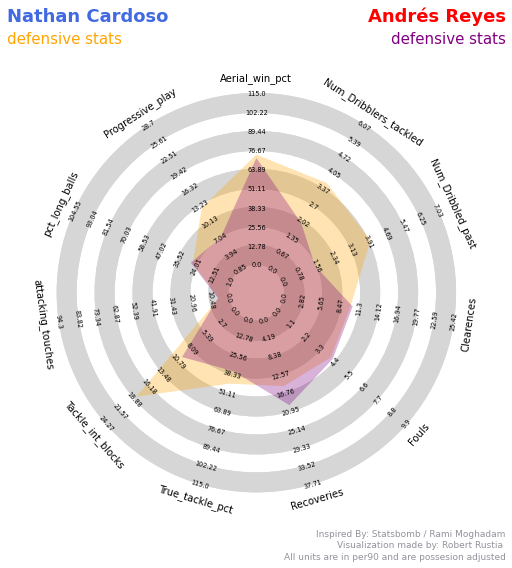

In [80]:
radar_compare('Nathan Cardoso','Andrés Reyes',params,cdf)

### Insight 
- Both players have very simular player profiles as volume defenders who are thrawting the opposings team attack directly, with both players highlighted in tackles interceptions blocks, recoveries and Aerial_win_pct. 

- Below comparison of skill groups ranks shows both players highligthed for progressive passing and short passing. 

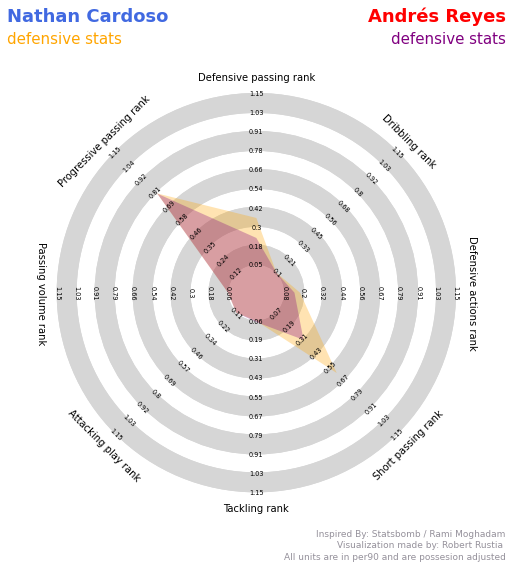

In [72]:
radar_compare('Nathan Cardoso','Andrés Reyes',ranks,dfw)

### 5.4.2 Julian Gressel, DC united, Wing back

In [73]:
JG = normed_df.loc['Julian Gressel']
# use .dot to get cosine simularity 
sims = normed_df.dot(JG)

# players with closest angle to Nathan Cardoso
sims.nlargest(5)

Julian Gressel           1.000000
Guðmundur Þórarinsson    0.965097
Brooks Lennon            0.955413
Ruan                     0.955302
Brad Smith               0.948897
dtype: float64

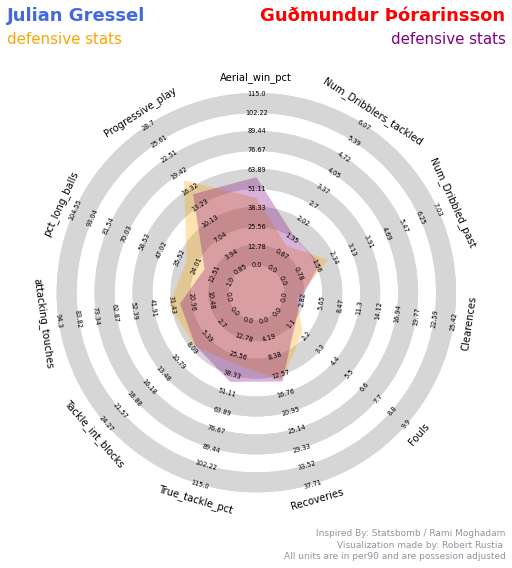

In [81]:
radar_compare('Julian Gressel','Guðmundur Þórarinsson',params,cdf)

### Insight - Guðmundur Þórarinsson who now players for AALBORG BKin the SUPERLIGAEN  after leaving NYC and their successful tital campain is closest to Julian Gressle. Both players are highligthed for their Progressive play on the ball, number of players dribbled past and recoveries. 

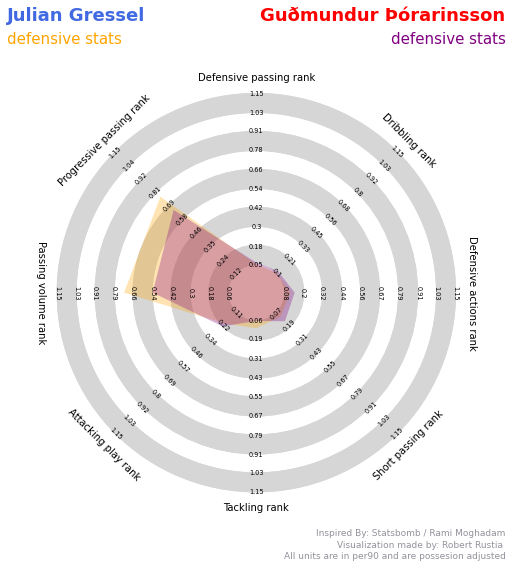

In [68]:
radar_compare('Julian Gressel','Guðmundur Þórarinsson',ranks,dfw)

In [97]:
### 5.4.3 Hector Jimenez , Austin FC , Defender

In [98]:
HJ = normed_df.loc['Hector Jiménez']
# use .dot to get cosine simularity 
sims = normed_df.dot(HJ)

# players with closest angle to Nathan Cardoso
sims.nlargest(5)

Hector Jiménez        1.000000
Harrison Afful        0.979864
João Moutinho         0.979183
Graham Zusi           0.977566
Cristián Gutiérrez    0.975640
dtype: float64

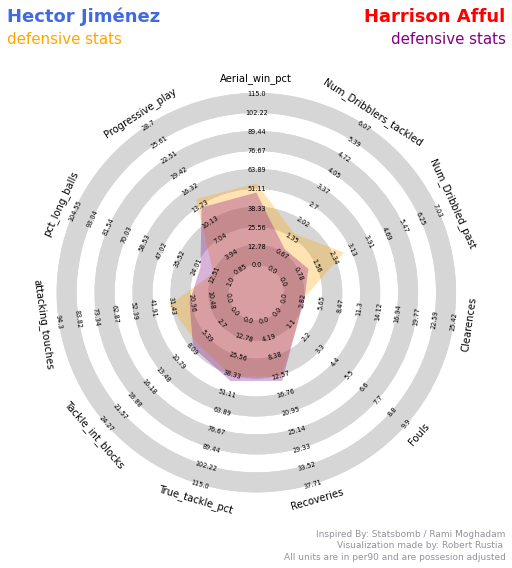

In [96]:
radar_compare('Hector Jiménez','Harrison Afful',params,cdf)

### 5.4.3 Insight 
- Harrison Afful plays as a fullback for Major League Soccer club Charlotte FC and the Ghana national team. Both players highlight there all around skills as well as thir Progressive play. 

- below The simularity in skill set can be seen with Harr

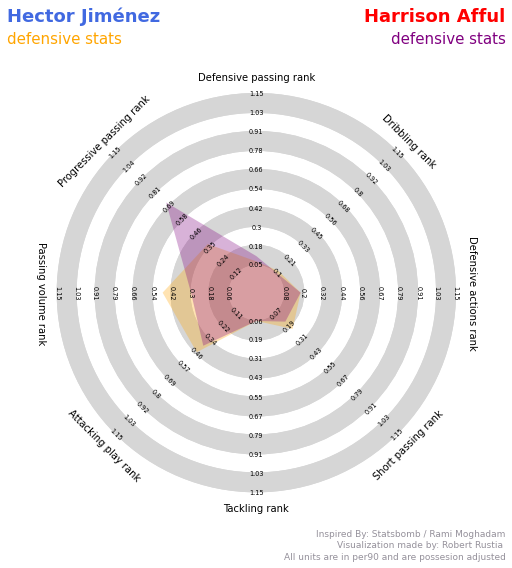

In [100]:
radar_compare('Hector Jiménez','Harrison Afful',ranks,dfw)

In [63]:
wz = normed_df.loc['Walker Zimmerman']
sims = normed_df.dot(wz)

sims.nlargest(10)

Walker Zimmerman     1.000000
Steve Birnbaum       0.967754
Tanner Beason        0.959139
Jonathan Mensah      0.953977
Bill Tuiloma         0.950487
Ranko Veselinović    0.943845
Omar Gonzalez        0.938170
Henry Kessler        0.929502
Sean Nealis          0.927017
Julio Cascante       0.924436
dtype: float64

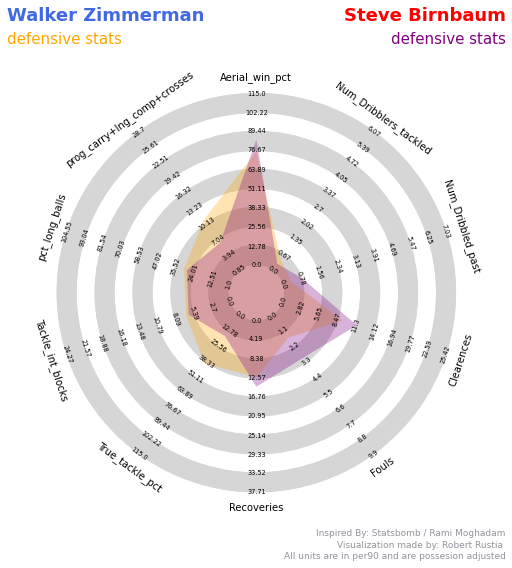

In [65]:
radar_compare('Walker Zimmerman','Steve Birnbaum',params,cdf)

In [38]:
jm = normed_df.loc['Jonathan Mensah']
sims = normed_df.dot(jm)

sims.nlargest(10)

Jonathan Mensah      1.000000
Tanner Beason        0.997402
Antonio Carlos       0.996732
Walker Zimmerman     0.996099
Oswaldo Alanís       0.995707
Ranko Veselinović    0.994264
Rudy Camacho         0.993281
Justen Glad          0.992826
Bill Tuiloma         0.992724
Xavier Arreaga       0.992455
dtype: float64

In [46]:
jm = normed_df.loc['Nathan Cardoso']
sims = normed_df.dot(jm)

sims.nlargest(10)

Nathan Cardoso          1.000000
Alan Franco             0.971050
Andrés Reyes            0.970232
Donovan Pines           0.965230
Francisco Calvo         0.959289
Johan Kappelhof         0.954601
Nick Hagglund           0.953494
Rodrigo Schlegel        0.950793
Gustavo Vallecilla      0.945636
Nicolas Isimat-Mirin    0.945454
dtype: float64